In [2]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd

from tqdm.auto import tqdm

from olfactory_navigation import Environment
from olfactory_navigation.agents import FSVI_Agent
from olfactory_navigation.simulation import run_test, SimulationHistory
from olfactory_navigation.test_setups import test_shape_robustness
from olfactory_navigation.visualization import plot_shape_robustness_performance, plot_full_shape_robustness_analysis

# Loading Environment

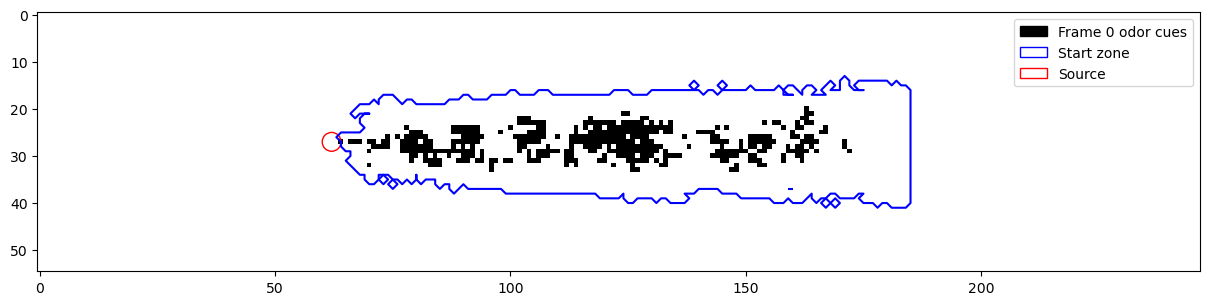

In [3]:
# data_file = "C:\\Users\\arnau\\Desktop\\Master Thesis Files [TO BACKUP]\\Data\\nose_data.npy"
data_file = "/storage/rando/data/nose_data.npy"

full_env = Environment(data_file=data_file,
                       data_source_position=[143,0],
                       source_radius=2,
                       shape=np.array([55,247]),
                       margins=[14,62],
                       boundary_condition='wrap_vertical',
                       start_zone='odor_present',
                       odor_present_threshold=3e-6
                       )

full_env.plot()

# Base Agent training

In [3]:
ag = FSVI_Agent(full_env)

[06/03/2024, 13:56:28] Instantiation of MDP Model:
[06/03/2024, 13:56:28] - 13585 states
[06/03/2024, 13:56:28] - 4 actions
[06/03/2024, 13:56:28] - At most 1 reachable states per state-action pair
[06/03/2024, 13:56:28] - Starting generation of transitions table
[06/03/2024, 13:56:28]     > [Warning] No transition matrix or function provided but reachable states are, so probability to reach any reachable states will "1 / reachable state count" so here: 1.000.
[06/03/2024, 13:56:28]     > Done in 0.000s
[06/03/2024, 13:56:28] - Generation of state grid
[06/03/2024, 13:56:28] - Generating start probabilities table
[06/03/2024, 13:56:28] - Starting computation of reachable state probabilities from transition data
[06/03/2024, 13:56:28]     > Done in 0.000s

[06/03/2024, 13:56:28] POMDP particular parameters:
[06/03/2024, 13:56:28] - 3 observations
[06/03/2024, 13:56:28] - Starting of transitional observations for reachable states table
[06/03/2024, 13:56:28]     > Done in 0.002s
[06/03/2

In [4]:
_ = ag.train(expansions=300, force=True, use_gpu=True)

[06/03/2024, 13:56:28] MDP_policy, not provided. Solving MDP with Value Iteration...
[06/03/2024, 13:56:28] Sending Model to GPU...
[06/03/2024, 13:56:29]     > Done in 1.016s


  0%|          | 0/1000 [00:00<?, ?it/s]

Summary of Value Iteration run
  - Model: 13585-state, 4-action
  - Converged in 918 iterations and 0.6608 seconds
  - Took on average 0.0007s per iteration


Expansions:   0%|          | 0/300 [00:00<?, ?it/s]

Summary of Point Based Value Iteration run
  - Model: 13585 state, 4 action, 3 observations
  - Converged or stopped after 300 expansion steps and 300 backup steps.
  - Resulting value function has 2168 alpha vectors.
  - Converged in 21.7735s

  - Expand function took on average 0.0083s and yielded on average 723.62 beliefs per iteration. (0.0001s/it/belief)
  - Backup function took on average 0.0643s and yielded on average 7.21 alpha vectors per iteration. (0.0003s/it/alpha)
  - Pruning function took on average 0.0000s and yielded on average prunings of 0.00 alpha vectors per iteration.


# Scale robustness test

In [5]:
mod_ag = ag.modify_environment(full_env.modify_scale(0.5))

[06/03/2024, 13:56:55] Instantiation of MDP Model:
[06/03/2024, 13:56:55] - 3321 states
[06/03/2024, 13:56:55] - 4 actions
[06/03/2024, 13:56:55] - At most 1 reachable states per state-action pair
[06/03/2024, 13:56:55] - Starting generation of transitions table
[06/03/2024, 13:56:55]     > [Warning] No transition matrix or function provided but reachable states are, so probability to reach any reachable states will "1 / reachable state count" so here: 1.000.
[06/03/2024, 13:56:55]     > Done in 0.000s
[06/03/2024, 13:56:55] - Generation of state grid
[06/03/2024, 13:56:55] - Generating start probabilities table
[06/03/2024, 13:56:55] - Starting computation of reachable state probabilities from transition data
[06/03/2024, 13:56:55]     > Done in 0.000s

[06/03/2024, 13:56:55] POMDP particular parameters:
[06/03/2024, 13:56:55] - 3 observations
[06/03/2024, 13:56:55] - Starting of transitional observations for reachable states table
[06/03/2024, 13:56:55]     > Done in 0.000s
[06/03/20

In [6]:
mod_ag.value_function.alpha_vector_array.shape

(2150, 3321)

In [7]:
from olfactory_navigation.test_setups import run_all_starts_test

hist = run_all_starts_test(mod_ag, use_gpu=True)

[06/03/2024, 13:59:28] Sending Model to GPU...
[06/03/2024, 13:59:28]     > Done in 0.002s


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulations done in 3.493s:
Simulations reached goal: 566/568 (2 failures) (99.65%)
	- Average step count: 47.129 +- 62.19 (Successfull only: 43.761 +- 25.74)
	- Extra steps: 12.099 +- 58.23 (Successful only: 8.731 +- 13.44)
	- Average discounted rewards (ADR): 0.661 +- 0.15 (Successfull only: 0.663 +- 0.15)
	- Tmin/T: 0.832 +- 0.15 (Successful only: 0.835 +- 0.15)


In [8]:
hist_orig = run_all_starts_test(ag, use_gpu=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

Simulations done in 4.506s:
Simulations reached goal: 2386/2393 (7 failures) (99.71%)
	- Average step count: 94.646 +- 70.39 (Successfull only: 91.990 +- 50.59)
	- Extra steps: 23.612 +- 54.48 (Successful only: 20.915 +- 22.10)
	- Average discounted rewards (ADR): 0.444 +- 0.20 (Successfull only: 0.445 +- 0.20)
	- Tmin/T: 0.797 +- 0.16 (Successful only: 0.799 +- 0.15)


# Shape robustness test

In [5]:
all_histories = test_shape_robustness(
    agent=ag,
    use_gpu=True
)

The results will be saved to: ./results/06032024_011007_robustness_test_55_247-marg_14_14_62_62-edge_wrap_vertical-start_odor_present-source_27_62_radius2



  0%|          | 0/63 [00:00<?, ?it/s]

Testing on environment with height 20% and width 20%
Using the provided environment, not the agent environment.
Simulations done in 11.399s:
Simulations reached goal: 1156/2393 (1237 failures) (48.31%)
	- Average step count: 600.350 +- 419.57 (Successfull only: 172.696 +- 103.09)
	- Extra steps: 529.316 +- 411.60 (Successful only: 106.363 +- 63.55)
	- Average discounted rewards (ADR): 0.141 +- 0.24 (Successfull only: 0.291 +- 0.28)
	- Tmin/T: 0.246 +- 0.21 (Successful only: 0.429 +- 0.17)
Simulations saved to: ./results/06032024_011007_robustness_test_55_247-marg_14_14_62_62-edge_wrap_vertical-start_odor_present-source_27_62_radius2/test_env_y-20_x-20.csv

Testing on environment with height 20% and width 40%
Using the provided environment, not the agent environment.
Simulations done in 9.087s:
Simulations reached goal: 1584/2393 (809 failures) (66.19%)
	- Average step count: 443.571 +- 406.18 (Successfull only: 159.384 +- 101.80)
	- Extra steps: 372.537 +- 395.35 (Successful only: 92.7

In [6]:
file = './results/06032024_011007_robustness_test_55_247-marg_14_14_62_62-edge_wrap_vertical-start_odor_present-source_27_62_radius2/_analysis.csv'
df = pd.read_csv(file)

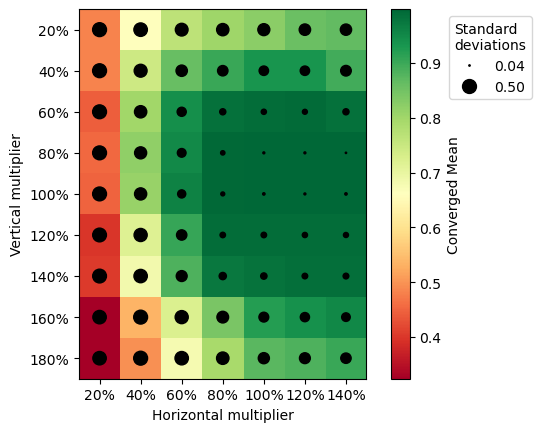

In [7]:
plot_shape_robustness_performance(df)

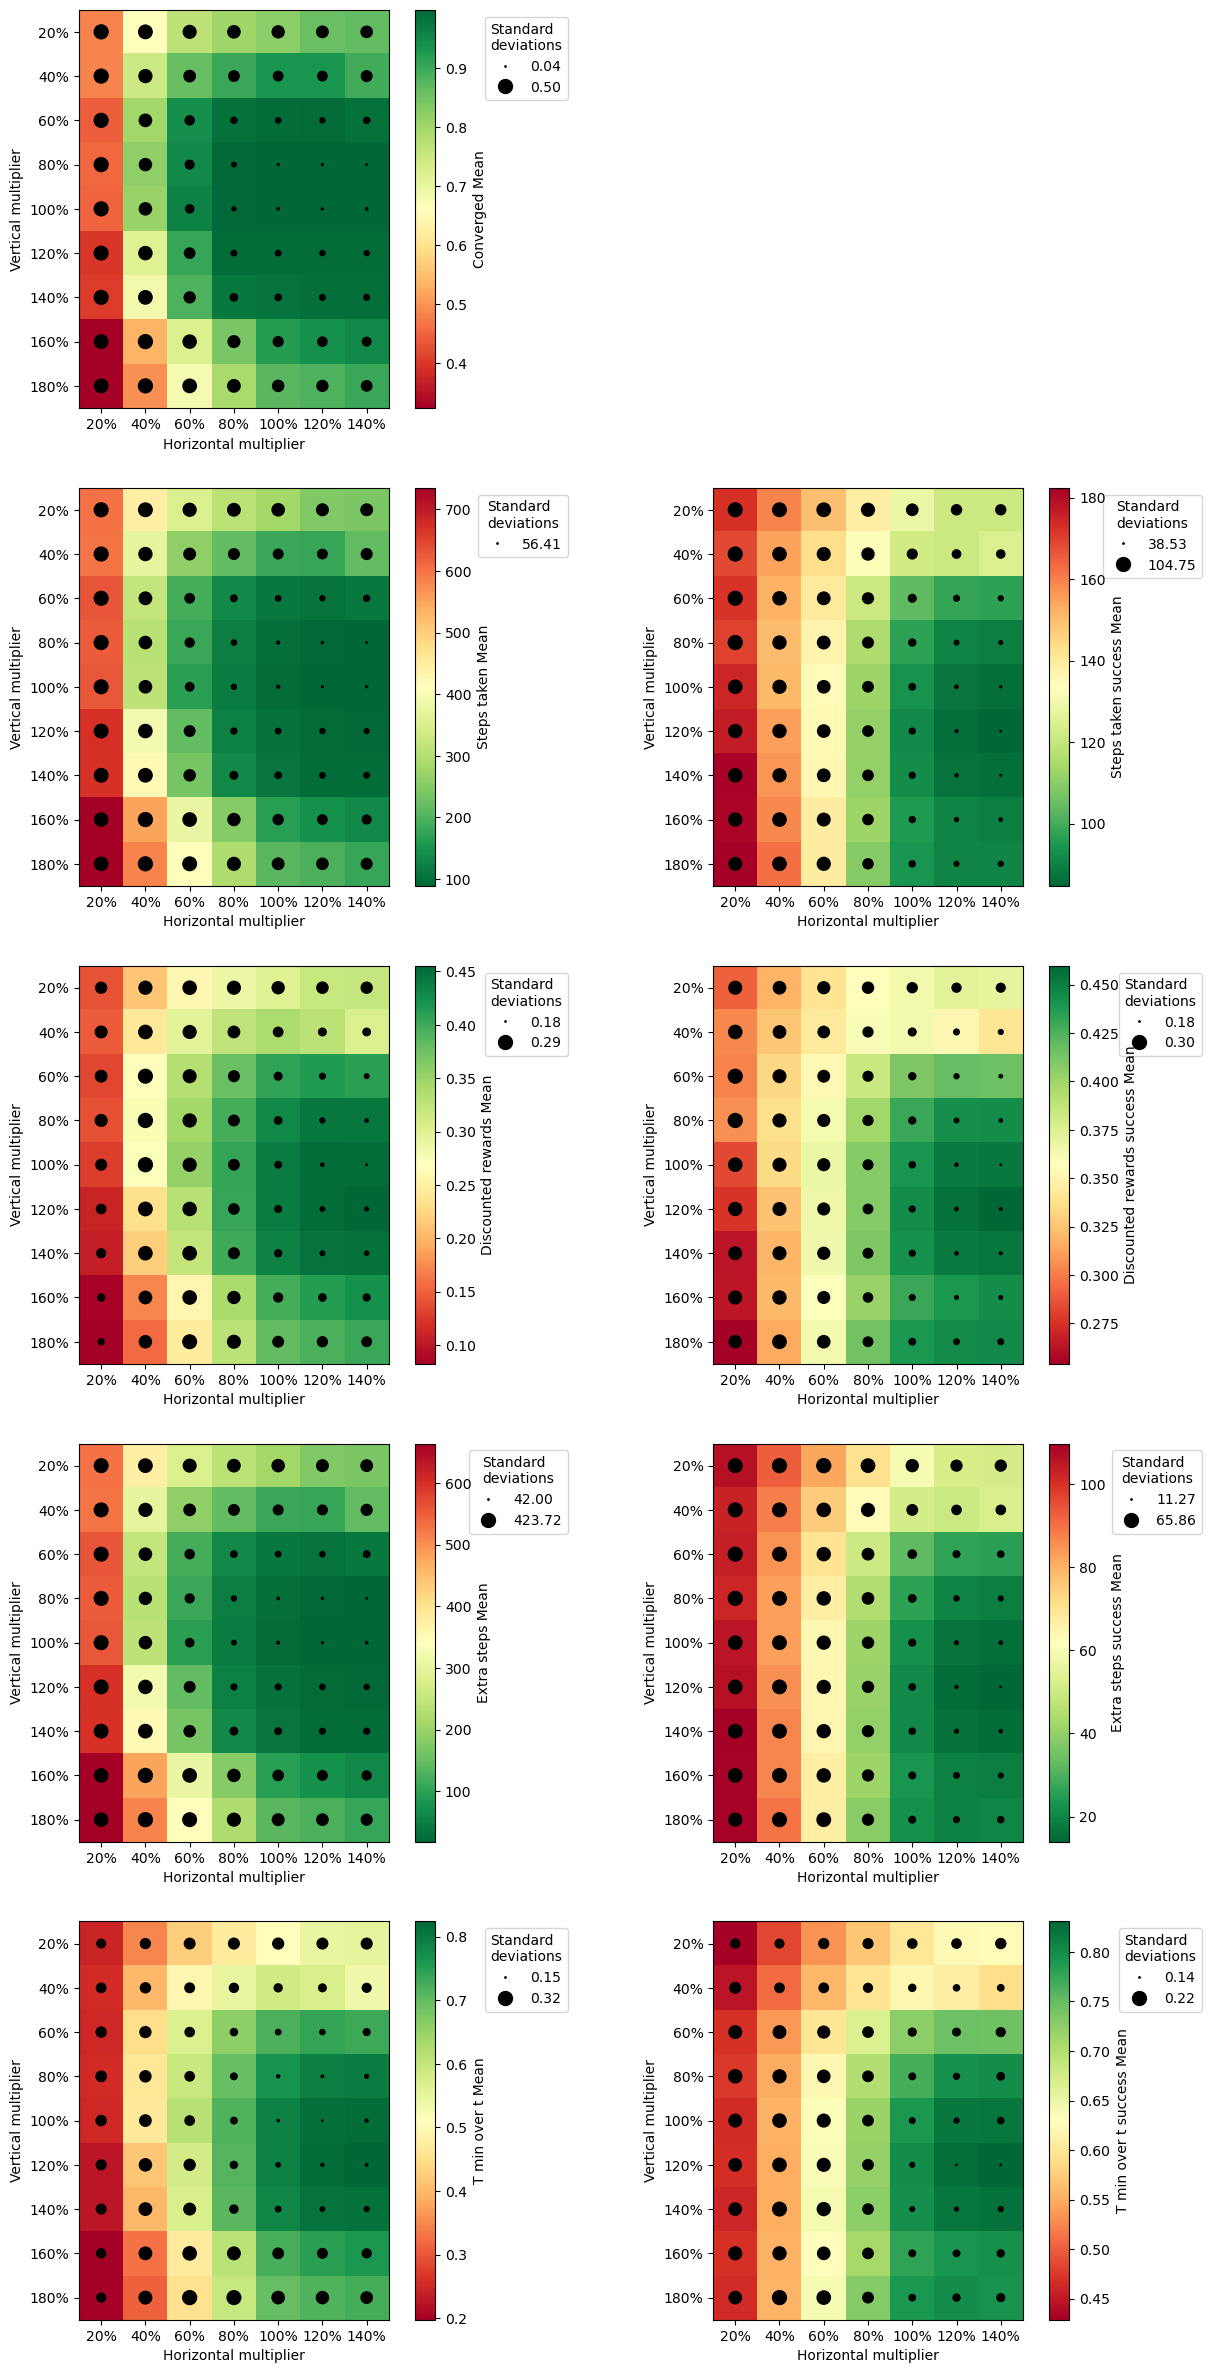

In [8]:
plot_full_shape_robustness_analysis(df)